In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy import stats
import random

Important: Because LSTM takes a lot of time to train, especially since we need to reconstruct the entire dataset; which requires us to have a lot more samples than a dataset for another anomaly detection method, I have split the DataCreation() into two parts: one for 500000 timestamps, and another for 2000 timestamps. This is to reduce training time for experimentation. Therefore, because the number of timestamps change drastically; to imitate the complexity of both datasets, we must change the frequency of the sine function as well as the partition lengths of the dataset(to combine different functions of sine in one function). Set LSTM parameter to 0 for non-LSTM models; set LSTM parameter to 1 for LSTM models.

In [624]:
class DataCreation():
    def __init__(self, sample_size, timestamps):
        self.sample_size = sample_size
        self.timestamps = timestamps
        
    def create_intervals(self, seed, LSTM):        
        random.seed(seed+100)
        intervals = []
        i = 0
        if LSTM == 0:
            # Use for non-LSTM
            while i <= self.timestamps:
                length = random.randint(200, 1000)
                if (i + length + 400) > self.timestamps:
                    sublist = list((i, self.timestamps))
                    intervals.append(sublist)
                    break
                else:
                    sublist = list((i, i+length-1))
                intervals.append(sublist)
                i = i + length
        
        else:
            # Use for LSTM
            while i <= self.timestamps:
                length = random.randint(100, 200)
                if (i + length + 200) > self.timestamps:
                    sublist = list((i, self.timestamps))
                    intervals.append(sublist)
                    break
                else:
                    sublist = list((i, i+length-1))
                intervals.append(sublist)
                i = i + length
        return intervals
    
    def create_df(self, seed, LSTM):
        self.f_x = np.array([])
        
        partitions_1 = self.create_intervals(seed, LSTM)
        partitions_2 = self.create_intervals(seed+1, LSTM)
        random.seed(seed)
        for i in range(len(partitions_1)):
            if LSTM == 0:
                freq = random.choice([6, 8])
            else:
                freq = random.choice([50, 52, 54])
            co_ef = random.uniform(8, 10)
            self.f_x = np.append(self.f_x, co_ef * np.sin(np.linspace(0, freq * np.pi, partitions_1[i][1] - partitions_1[i][0] + 1)))

        for i in range(len(partitions_2)):
            mean = 0
            variance = random.uniform(0.1, 2)
            self.f_x[partitions_2[i][0]:partitions_2[i][1]] = self.f_x[partitions_2[i][0]:partitions_2[i][1]] + np.random.normal(mean, variance, partitions_2[i][1] - partitions_2[i][0])
        
        self.f_x = self.f_x[:self.timestamps]
        return self.f_x
    
    def train_test_split(self, split):
        g_x = self.f_x.reshape(self.timestamps // self.sample_size, self.sample_size)
        split = round(len(g_x) * split)
        self.train_X = g_x[:split]
        self.test_X = g_x[split:]
        
    def faulty_point_data(self, test_data, seed):
        test_data_reshaped = test_data.reshape(test_data.shape[0] * test_data.shape[1])
        random.seed(seed)
        num_anomalies = random.randint(1000, 1500)
        self.normal_timestamps = [i for i in range(len(test_data_reshaped))]
        self.anomaly_timestamps = []
        for i in range(num_anomalies):
            anomaly = random.choice(self.normal_timestamps)
            self.anomaly_timestamps.append(anomaly)
            self.normal_timestamps.remove(anomaly)
        for anomaly in self.anomaly_timestamps:
            if anomaly < 50:
                mean, std = test_data_reshaped[anomaly:anomaly+50].mean(), test_data_reshaped[anomaly:anomaly+50].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            elif anomaly > len(test_data_reshaped)-50:
                mean, std = test_data_reshaped[anomaly-50:anomaly].mean(), test_data_reshaped[anomaly-50:anomaly].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
            else:
                mean, std = test_data_reshaped[anomaly-25:anomaly+25].mean(), test_data_reshaped[anomaly-25:anomaly+25].std()
                if random.choice([0, 1]) == 1:
                    test_data_reshaped[anomaly] = mean + random.uniform(3*std, 3.5*std)
                else:
                    test_data_reshaped[anomaly] = mean - random.uniform(3*std, 3.5*std)
        return test_data_reshaped
    
    def faulty_collective_data(self, data, num_anomalies, len_anomaly, seed):
        random.seed(seed)
        temp = []
        self.anomaly_timestamps = []
        self.normal_timestamps = [i for i in range(len(data))]
        for i in range(num_anomalies):
            anomaly = random.randint(i*(len(data)//num_anomalies), (i+1)*(len(data)//num_anomalies)-len_anomaly)
            temp.append(anomaly)
            self.anomaly_timestamps.extend([i for i in range(anomaly, anomaly+len_anomaly)])
            unwanted_num = set([i for i in range(anomaly, anomaly+len_anomaly)])
            self.normal_timestamps = [ele for ele in self.normal_timestamps if ele not in unwanted_num]
        for anomaly in temp:
            data[anomaly:anomaly+len_anomaly] = data[anomaly]
        return data
        
    def plot_df(self, sample, size):
        plt.figure(figsize=(12, 6))
        plt.plot(self.f_x)
        plt.xlim([sample*size, sample*size + size])

### Autoencoders

#### Point Anomalies

In [113]:
sample_size, timestamps = 500, 500000

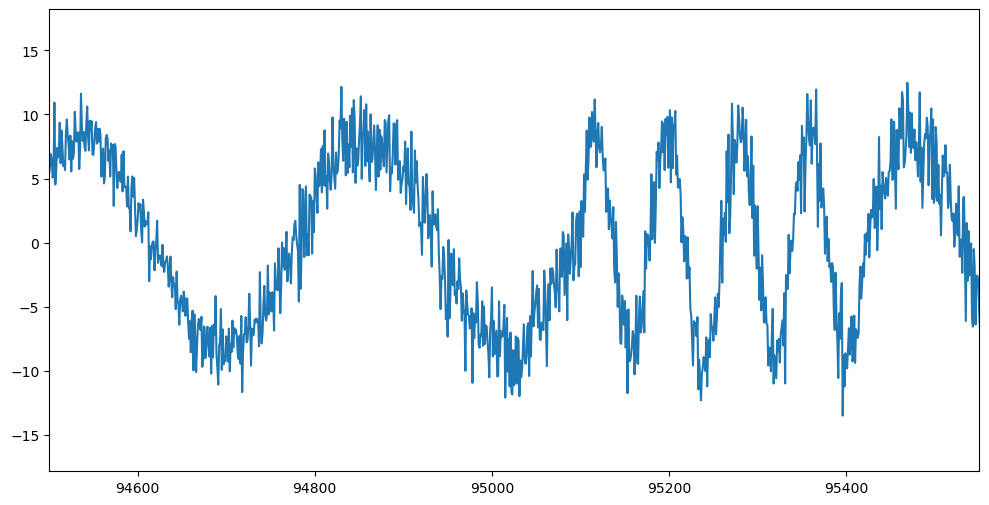

In [114]:
data = DataCreation(sample_size, timestamps)
f_x = data.create_df(200, 0)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X
data.plot_df(90, 1050)

In [437]:
test_X_reshaped = data.faulty_data(test_X, 14000)

Create faulty point anomalies in testing data

In [438]:
# Autoencoder
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=50, restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(256, input_shape=(sample_size,), activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(sample_size)
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = model.fit(train_X, train_X, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

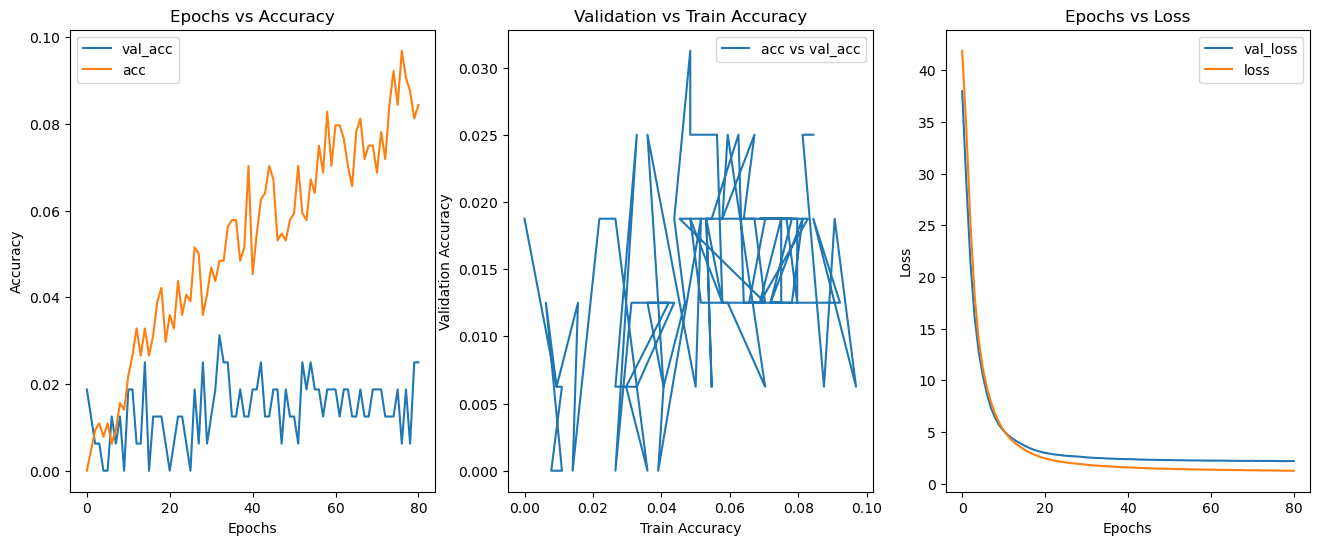

In [439]:
plt.figure(figsize=(16, 6))
h = history.history
plt.subplot(131)
plt.plot(range(len(h['val_accuracy'])), h['val_accuracy'], label='val_acc')
plt.plot(range(len(h['accuracy'])), h['accuracy'], label='acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"Epochs vs Accuracy")

plt.subplot(132)
plt.plot(h['accuracy'], h['val_accuracy'], label='acc vs val_acc')
plt.xlabel("Train Accuracy")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title(f"Validation vs Train Accuracy")
        
plt.subplot(133)
plt.plot(range(len(h['val_loss'])), h['val_loss'], label='val_loss')
plt.plot(range(len(h['loss'])), h['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Epochs vs Loss")
plt.show()

#### Static threshold 

To improve organization of code, convert code blocks below into function; possibly into a class if needed

In [440]:
test_X_rec = model.predict(test_X)
test_X_rec = test_X_rec.reshape(test_X_rec.shape[0] * test_X_rec.shape[1])
p, r, f1 = [], [], []
for i in range(200):
    times = set([i for i in range(len(test_X_rec))])
    threshold = 2 + 0.1 * i
    anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)
    tp = np.sum(np.isin(anomaly_timestamps, anomalies[0]))
    fp = np.sum(np.isin(normal_timestamps, anomalies[0]))
    tn = np.sum(np.isin(np.array(list(times - set(anomalies[0]))), anomalies[0]))
    fn = np.sum(np.isin(np.array(list(times - set(anomalies[0]))), anomaly_timestamps))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))

7/7 [==============================] - 0s 2ms/step


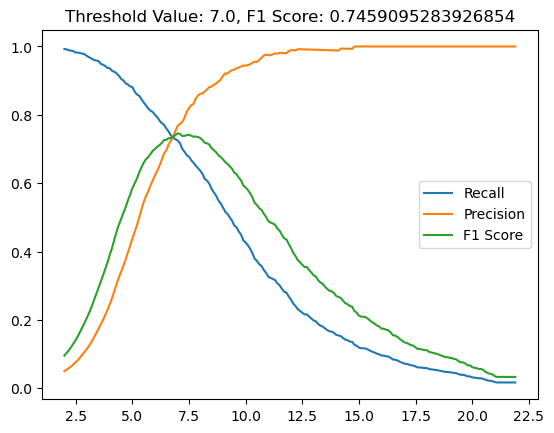

In [441]:
plt.title(f"Threshold Value: {2 + 0.1 * f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [2 + 0.1 * i for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [442]:
threshold = 7
anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)
print(f"Threshold Value: {threshold}")
print(f"Accuractely Detected Anomalies out of {len(anomaly_timestamps)}: {np.sum(np.isin(anomaly_timestamps, anomalies[0]))}")
print(f"False Alarms out of {len(normal_timestamps)}: {np.sum(np.isin(normal_timestamps, anomalies[0]))}")

Threshold Value: 7
Accuractely Detected Anomalies out of 1069: 775
False Alarms out of 98931: 234


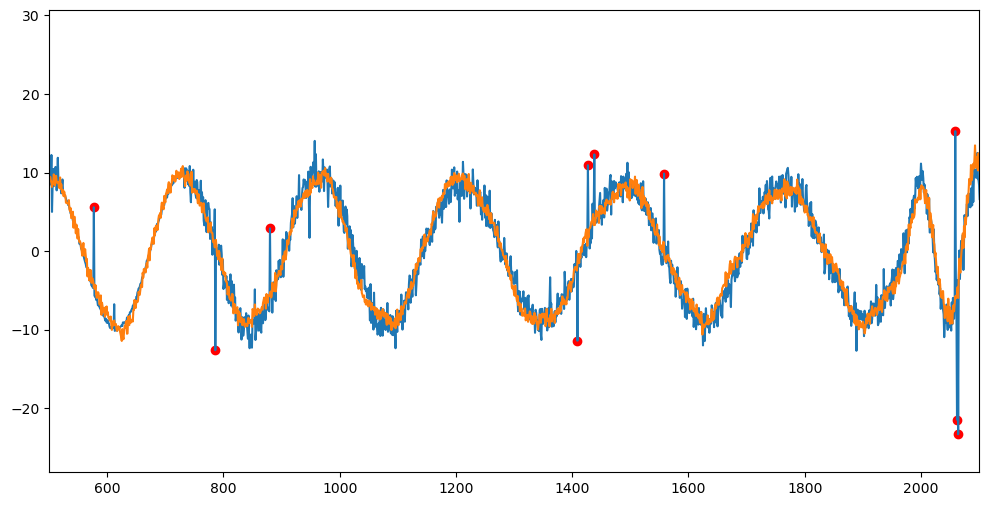

In [445]:
threshold = 7
anomalies = np.where(np.abs(test_X_reshaped - test_X_rec) > threshold)

i = 1
plt.figure(figsize=(12, 6))
plt.plot(test_X_reshaped)
plt.plot(test_X_rec)
plt.scatter(anomalies, test_X_reshaped[anomalies], color='red')
plt.xlim([i*500, i*500 + 1600])
plt.show()

Two methods to anomaly detection: 
<br>1. Using autoencoders, then finding threshold value using f1 score
<br>2. Moving median, calculate the median absolute deviation, and see if a point deviates away from 3 MADs

### Moving Average

In [161]:
data = DataCreation(500, 500000)
f_x = data.create_df(100, 0)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X

In [162]:
test_X = data.faulty_point_data(test_X, 14000)

If we want moving average, we use np.mean(window), and np.std(np.array(window))

In [112]:
def evaluate_MM(data, window_size, timestamps):
    interval = window_size // 2
    moving_average = [np.nan for i in range(interval)]
    standard_dev = [np.nan for i in range(interval)]
    for i in range(interval, timestamps - interval):
        window = data[i - interval:i + interval]
        window_average = np.median(window)
        standard_dev.append(stats.median_abs_deviation(np.array(window)))
        moving_average.append(window_average)
    anomalies = []
    for i in range(window_size//2, timestamps - window_size):
        threshold_1 = moving_average[i] + 3 * standard_dev[i]
        threshold_2 = moving_average[i] - 3 * standard_dev[i]
        if data[i] > threshold_1 or data[i] < threshold_2:
            anomalies.append(i)
    anomalies = np.array(anomalies)
    return anomalies

In [ ]:
p, r, f1 = [], [], []
for window_size in range(15, 200):
    times = set([i for i in range(len(test_X))])
    anomalies = evaluate_MM(test_X, window_size, timestamps=len(test_X))
    tp = np.sum(np.isin(data.anomaly_timestamps, anomalies))
    fp = np.sum(np.isin(data.normal_timestamps, anomalies))
    tn = np.sum(np.isin(np.array(list(times - set(anomalies))), anomalies))
    fn = np.sum(np.isin(np.array(list(times - set(anomalies))), data.anomaly_timestamps))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))

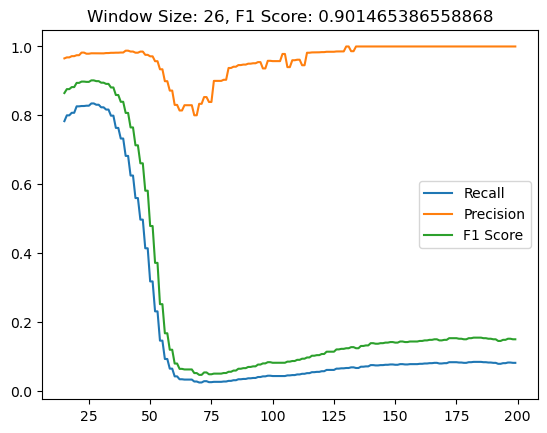

In [462]:
plt.title(f"Window Size: {15+f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [15+i for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

Use best window size to create smoothed dataset

In [102]:
timestamps = len(test_X)
window_size = 26
medians = np.zeros(window_size // 2).tolist()
standard_dev = np.zeros(window_size // 2).tolist()
for i in range(timestamps-window_size // 2):
    window = test_X[i-window_size:i]
    window_median = np.median(window)
    standard_dev.append(stats.median_abs_deviation(np.array(window)))
    medians.append(window_median)
np.array(standard_dev)

array([0.        , 0.        , 0.        , ..., 1.3069922 , 1.30745552,
       1.23441274])

In [103]:
anomalies, lb, ub = [], np.zeros(window_size // 2).tolist(), np.zeros(window_size // 2).tolist()
for i in range(window_size//2, timestamps - window_size // 2):
    threshold_1 = medians[i] + 3 * standard_dev[i]
    threshold_2 = medians[i] - 3 * standard_dev[i]
    if temp[i] > threshold_1 or temp[i] < threshold_2:
        anomalies.append(i)
    lb.append(threshold_2)
    ub.append(threshold_1)
np.array(anomalies)[:5]

array([ 84,  94,  96, 192, 234])

In [104]:
print(f"Accuractely Detected Anomalies out of {len(data.anomaly_timestamps)}: {np.sum(np.isin(data.anomaly_timestamps, anomalies))}")
print(f"False Alarms out of {len(data.normal_timestamps)}: {np.sum(np.isin(data.normal_timestamps, anomalies))}")

Accuractely Detected Anomalies out of 1069: 1069
False Alarms out of 98931: 1297


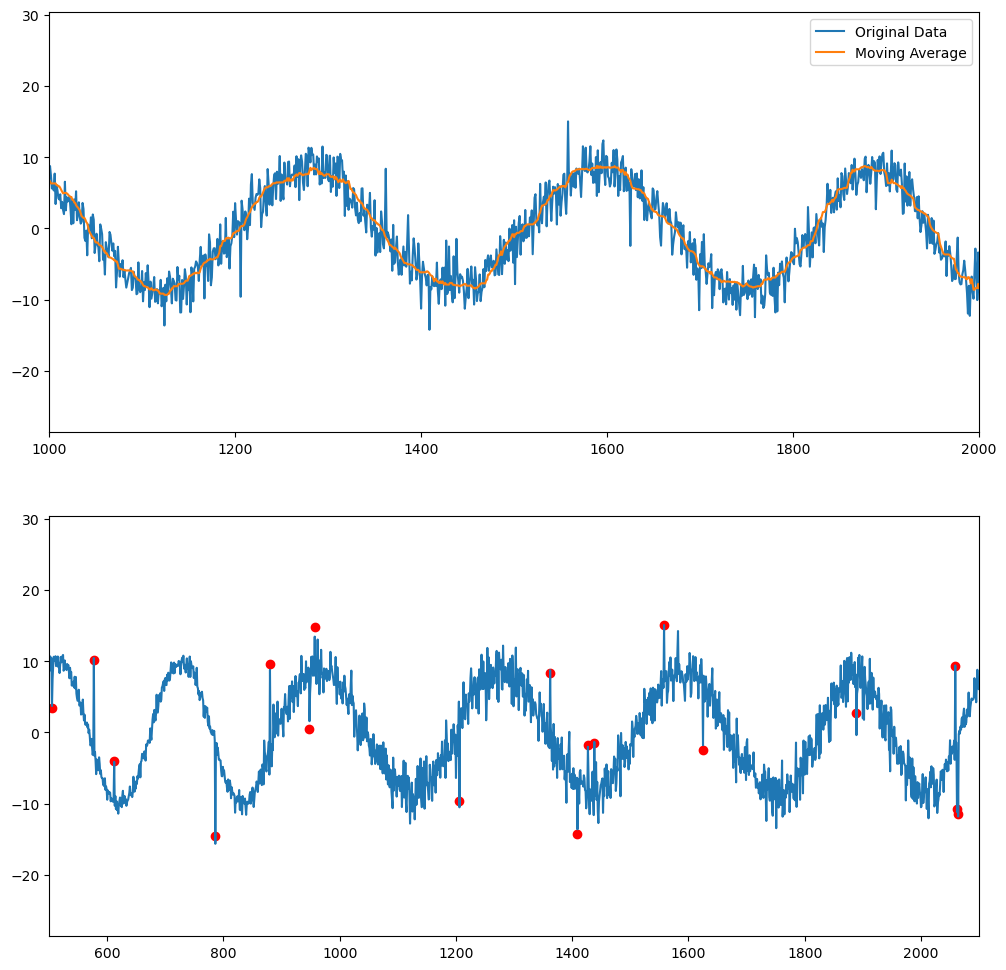

In [163]:
i = 1
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(temp, label='Original Data')
plt.plot(medians, label='Moving Average')
plt.legend()
# plt.plot(lb)
# plt.plot(ub)
# plt.scatter(anomalies, temp[anomalies], color='red')
plt.xlim([i*1000, i*1000 + 1000])
plt.subplot(212)
plt.plot(test_X)
plt.scatter(data.anomaly_timestamps, temp[data.anomaly_timestamps], color='r')
plt.xlim([i*500, i*500 + 1600])
plt.show()

#### Robust Random Cut Forest

Another Method for Anomaly Detection, however I was not able to make it work. 

In [6]:
import rrcf

In [7]:
data = DataCreation(500, 500000)
f_x = data.create_df(100, 0)
data.train_test_split(0.8)
train_X = data.train_X
test_X = data.test_X

In [8]:
test_X = data.faulty_data(test_X, 14000)
train_X = train_X.reshape(train_X.shape[0] * train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], 1)

In [16]:
n = test_X.shape[0]
d = test_X.shape[1]

In [629]:
forest = []
num_trees = 100
tree_size = 500
sample_size_range = (n // tree_size, tree_size)

while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(train_X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [630]:
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [65]:
data.anomaly_timestamps

[25532,
 25284,
 42210,
 26096,
 90198,
 33275,
 88793,
 6642,
 73496,
 86454,
 27547,
 60314,
 29643,
 3665,
 7762,
 30293,
 95049,
 57916,
 65907,
 55161,
 31565,
 76960,
 80948,
 8147,
 88703,
 82949,
 52606,
 59513,
 36039,
 84818,
 51679,
 52936,
 38044,
 20778,
 57832,
 10654,
 18046,
 81251,
 88700,
 61287,
 89530,
 27675,
 89901,
 98376,
 3068,
 29625,
 75378,
 64353,
 20101,
 18195,
 6836,
 69102,
 70837,
 62090,
 63977,
 65297,
 8941,
 9855,
 49091,
 612,
 34108,
 97078,
 13129,
 47428,
 13403,
 54408,
 60905,
 55180,
 31320,
 49943,
 75016,
 33265,
 29959,
 59988,
 89332,
 75803,
 3057,
 49548,
 38792,
 38854,
 18574,
 85176,
 58708,
 49869,
 10957,
 45739,
 93280,
 36184,
 2909,
 54746,
 42280,
 15517,
 68683,
 53064,
 9866,
 32467,
 78914,
 24706,
 14769,
 65610,
 18265,
 30483,
 98549,
 89117,
 59045,
 45962,
 6148,
 30396,
 72195,
 53788,
 17604,
 64419,
 5294,
 19625,
 30420,
 80225,
 76037,
 21789,
 80175,
 33353,
 91453,
 87236,
 62017,
 57997,
 957,
 42741,
 20924,
 

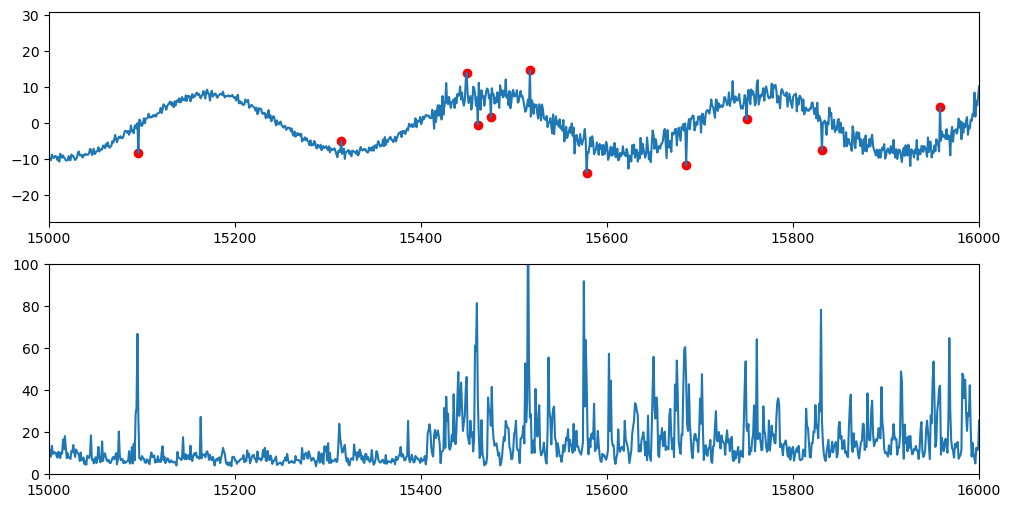

In [93]:
i = 15
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(test_X)
plt.scatter(data.anomaly_timestamps, test_X[data.anomaly_timestamps], color='red')
plt.xlim([i*1000, i*1000 + 1000])
plt.subplot(212)
plt.plot(avg_codisp)
plt.xlim([i*1000, i*1000 + 1000])
plt.ylim([0, 100])
plt.show()

In [40]:
def RRCT(data):
    arr = np.array([])
    codisp = [0, 0]
    for i in range(2):
        shingle = np.array([data[i], data[i+1], data[i+2], data[i+3]]).reshape(1, -1)
        arr = np.append(arr, shingle)
    arr = arr.reshape(2, 4)
    tree = rrcf.RCTree(arr)
    for i in range(5, len(test_X)):
        shingle = np.array([data[i-3], data[i-2], data[i-1], data[i]]).reshape(1, -1)
        tree.insert_point(shingle, index=i-3)
        codisp.append(tree.codisp(i-3))
        if tree.codisp(i-3) > 100:
            tree.forget_point(i-3)
    return tree, codisp

In [42]:
# forest = []
# for i in range(100):
#     tree, codisp = RRCT(test_X)
#     forest.extend([tree])
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [677]:
arr = np.array([])
for i in range(2):
    shingle = np.array([test_X[i], test_X[i+1], test_X[i+2], test_X[i+3]]).reshape(1, -1)
    arr = np.append(arr, shingle)
arr = arr.reshape(2, 4)
tree = rrcf.RCTree(arr)

In [656]:
codisp = [0, 0]
for i in range(5, len(temp)):
    shingle = np.array([test_X[i-3], test_X[i-2], test_X[i-1], test_X[i]]).reshape(1, -1)
    tree.insert_point(shingle, index=i-3)
    codisp.append(tree.codisp(i-3))

In [662]:
len(codisp)

99997

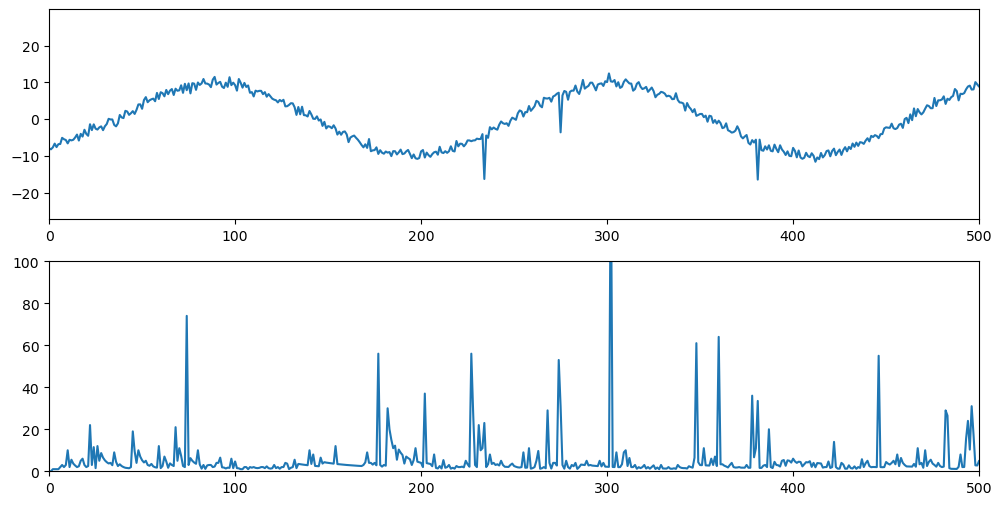

In [660]:
i = 0
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(temp)
plt.xlim([i*1000, i*1000 + 500])
plt.subplot(212)
plt.plot(codisp)
plt.xlim([i*1000, i*1000 + 500])
plt.ylim([0, 100])
plt.show()

### Autoencoders

#### Collective Anomalies

In [728]:
data = DataCreation(100, 2000)
f_x = data.create_df(100, 1)
data.train_test_split(0.5)
train_X = data.train_X
test_X = data.test_X

In [729]:
train_samples, test_samples = train_X.shape[0], test_X.shape[0]
length = train_X.shape[1]
train_X = train_X.reshape(train_X.shape[0] * train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0] * test_X.shape[1])

In [730]:
test_X = data.faulty_collective_data(test_X, 5, 20, 3)

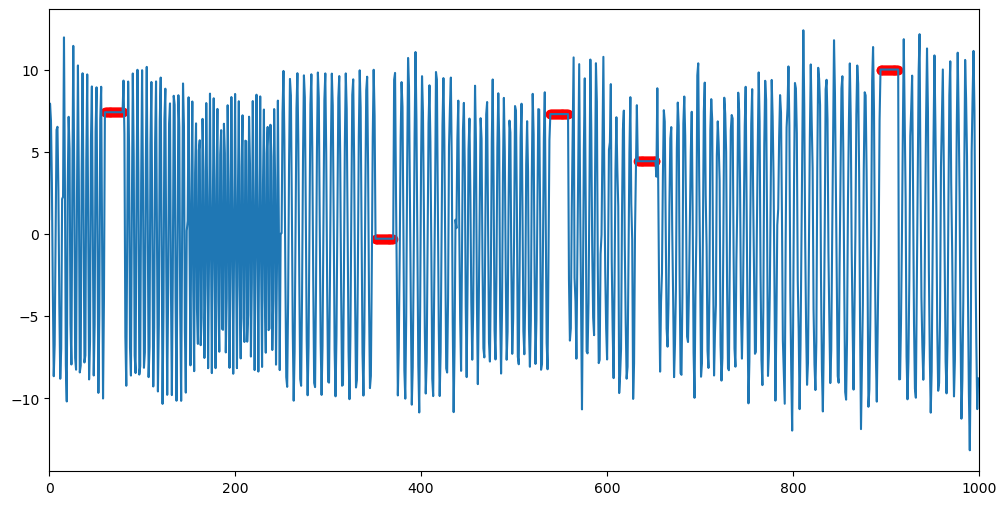

In [731]:
i = 0
plt.figure(figsize=(12, 6))
plt.plot(test_X)
plt.scatter(data.anomaly_timestamps, test_X[data.anomaly_timestamps], color='r')
plt.xlim([i*1000, i*1000 + 1000])
plt.show()

Because of difficulties converting the moving average to desired shape, I added zeros to the end of the dataset so that it is able to divide the entire dataset to shape (samples, length). For anomaly detection testing, remember to remove those zeros from the data. In addition, we can (and should) also remove the last sample from training altogether; for LSTM Autoencoders, this would correspond to the last window_size amount of samples.

In [732]:
# Apply Moving Average to smooth time series

def moving_average(data, window_size):
    timestamps = len(data)
    mean = []
    for i in range(window_size // 2, timestamps - window_size // 2):
        window = data[i-window_size // 2:i + window_size // 2+1]
        mean.append(np.mean(window))
    mean.extend(np.zeros(window_size).tolist())
    mean = np.array(mean)
    return mean

In [733]:
window_size = 3
train_mean = moving_average(train_X, window_size)
test_mean = moving_average(test_X, window_size)

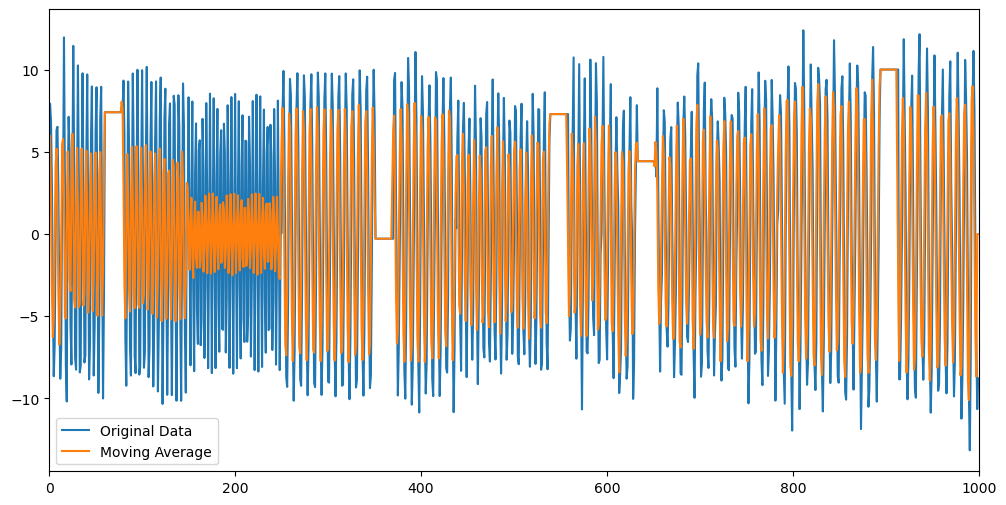

In [734]:
plt.figure(figsize=(12, 6))
i = 0
plt.plot(test_X, label='Original Data')
plt.plot(test_mean, label='Moving Average')
plt.legend()
plt.xlim([i*1000, i*1000 + 1000])
plt.show()

In [735]:
train_mean, test_mean = train_mean[:-1], test_mean[:-1]
scaler = MinMaxScaler()
train_mean = scaler.fit_transform(pd.DataFrame({'values': train_mean}))
test_mean = scaler.fit_transform(pd.DataFrame({'values': test_mean}))
test_mean.shape

In [736]:
train_mean = train_mean.reshape(train_samples, length)
test_mean = test_mean.reshape(test_samples, length)

In [737]:
# Autoencoder
early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=50, restore_best_weights=True)

model = keras.Sequential([
    layers.Dense(256, input_shape=(length,), activation='relu'),
    layers.Dense(128, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(length)
])
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = model.fit(train_mean, train_mean, epochs=200, batch_size=128, validation_split=0.2, 
                    verbose=0)

In [738]:
test_X = test_X.reshape(test_samples, length)
test_X.shape

(10, 100)

In [739]:
test_X_rec = model.predict(test_mean)
test_X_rec = test_X_rec.reshape(test_samples * length)
test_mean = test_mean.reshape(test_samples * length)

1/1 [==============================] - 0s 46ms/step


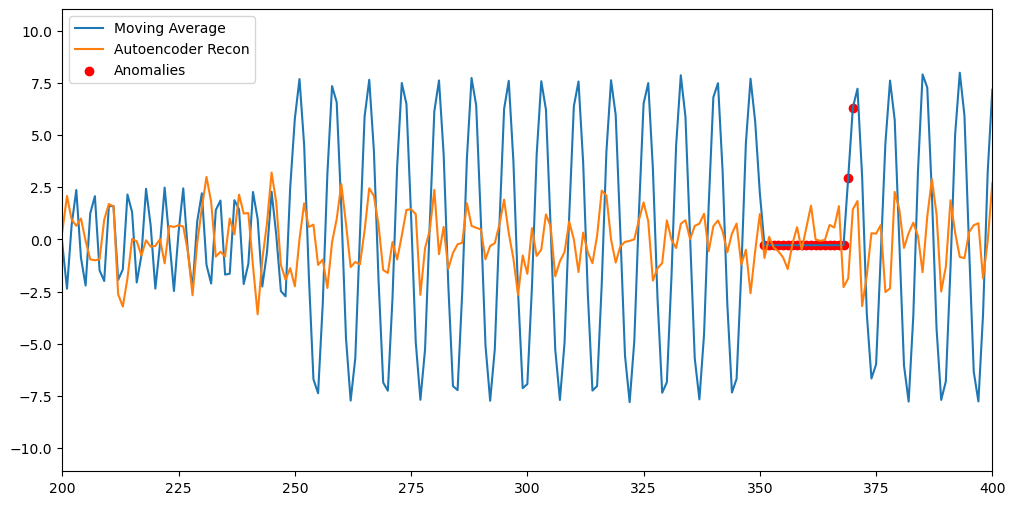

In [744]:
i = 2
plt.figure(figsize=(12, 6))
plt.plot(test_mean, label='Moving Average')
plt.plot(test_X_rec, label="Autoencoder Recon")
plt.scatter(data.anomaly_timestamps, test_mean[data.anomaly_timestamps], color='r', label='Anomalies')
plt.legend()
plt.xlim([i*100, i*100 + 200])
plt.show()

In [741]:
error = abs(test_mean - test_X_rec)
error.shape

(1000,)

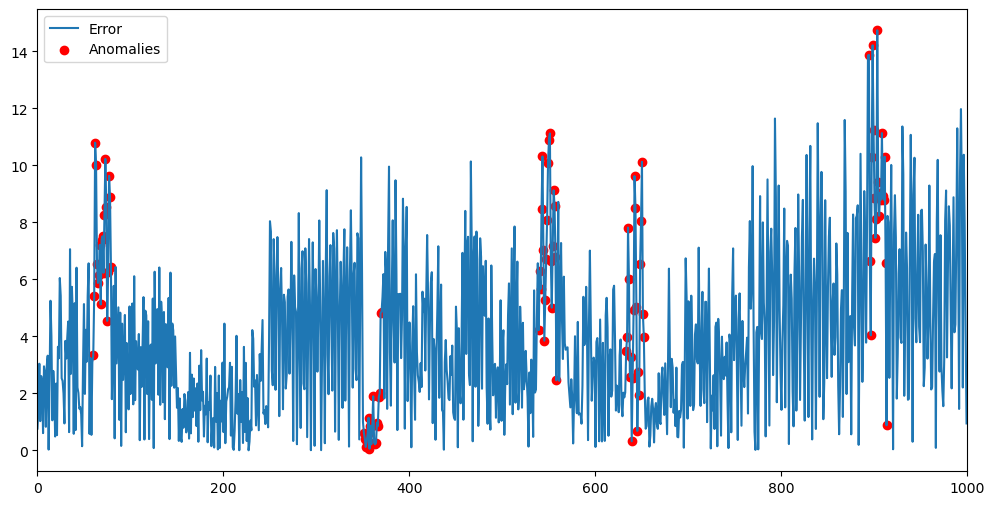

In [742]:
i = 0
plt.figure(figsize=(12, 6))
plt.plot(error, label='Error')
plt.scatter(data.anomaly_timestamps, error[data.anomaly_timestamps], color='r', label='Anomalies')
plt.legend()
plt.xlim([i*1000, i*1000 + 1000])
plt.show()

#### LSTM Autoencoder

Unlike other models, normalization is required for LSTM neural networks

In [774]:
data = DataCreation(100, 2000)
f_x = data.create_df(100, 1)
data.train_test_split(0.5)
train_X = data.train_X
test_X = data.test_X

In [775]:
train_samples, test_samples = train_X.shape[0], test_X.shape[0]
length = train_X.shape[1]
train_X = train_X.reshape(train_X.shape[0] * train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0] * test_X.shape[1])

In [776]:
test_X = data.faulty_collective_data(test_X, 5, 20, 4)

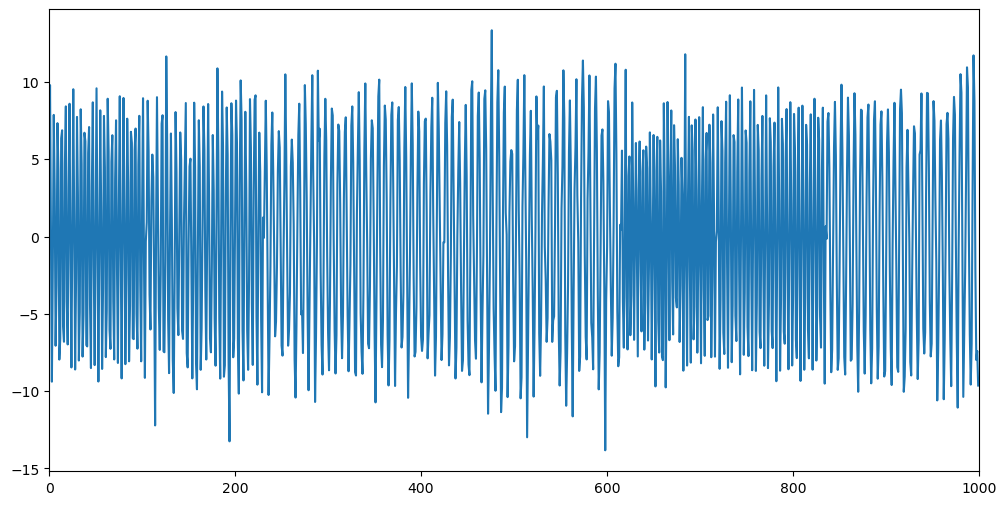

In [777]:
i = 0
plt.figure(figsize=(12, 6))
plt.plot(train_X)
plt.xlim([i*1000, i*1000 + 1000])
plt.show()

In [778]:
window_size = 3
train_mean = moving_average(train_X, window_size)
test_mean = moving_average(test_X, window_size)

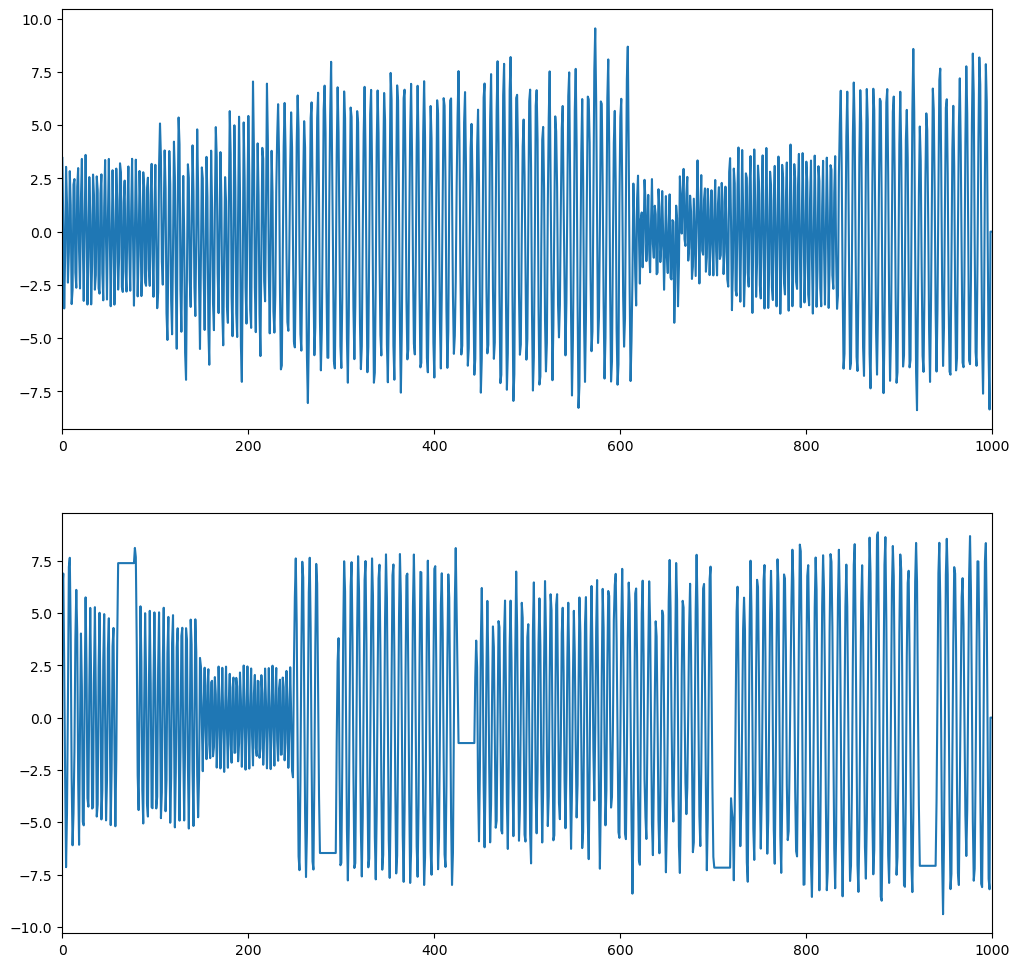

In [779]:
i = 0
plt.figure(figsize=(12, 12))
plt.subplot(211)
#plt.plot(train_X)
plt.plot(train_mean)
plt.xlim([i*1000, i*1000 + 1000])
plt.subplot(212)
#plt.plot(test_X)
plt.plot(test_mean)
plt.xlim([i*1000, i*1000 + 1000])
plt.show()

In [780]:
scaler = MinMaxScaler()
train_mean = scaler.fit_transform(pd.DataFrame({'values': train_mean}))
test_mean = scaler.fit_transform(pd.DataFrame({'values': test_mean}))
test_mean.shape

(1001, 1)

to_sequences() function can be used in any problem that requires LSTM. LSTM requires that the input data shape be in shape (samples, timestamps, features). For a regular LSTM model, we can simply partition entire dataset into equally spaced timestamps(no overlap between samples). When we evaluate predictions, however, we are only able to predict a subset of values in the dataset. 

However, for an anomaly detection problem, we require that we reconstruct the entire dataset. Therefore, we must use the 'sliding window' technique: 1st sample contains $\{t_0, t_1, t_2, \dots, t_n\}$, 2nd sample contains $\{t_1, t_2, t_3\dots, t_{n+1}\}$, etc. For every sample, we want to predict the next timestamp. So for the 1st sample, we want to predict $\hat{t}_{n+1}$. Therefore, we are only able to reconstruct the dataset minus the first n=window_size data points.

In [781]:
def to_sequences(x, y, seq_size):
    x_values, y_values = [], []
    for i in range(len(x) - seq_size):
        x_values.append(x[i:(i+seq_size)])
        y_values.append(y[i+seq_size])
    x_values, y_values = np.array(x_values), np.array(y_values)
    x_values = x_values.reshape(x_values.shape[0], x_values.shape[1], 1)
    return x_values, y_values

In [782]:
seq_size = 100
trainX, trainY = to_sequences(train_mean, train_mean, seq_size)
testX, testY = to_sequences(test_mean, test_mean, seq_size)
trainX.shape

(901, 100, 1)

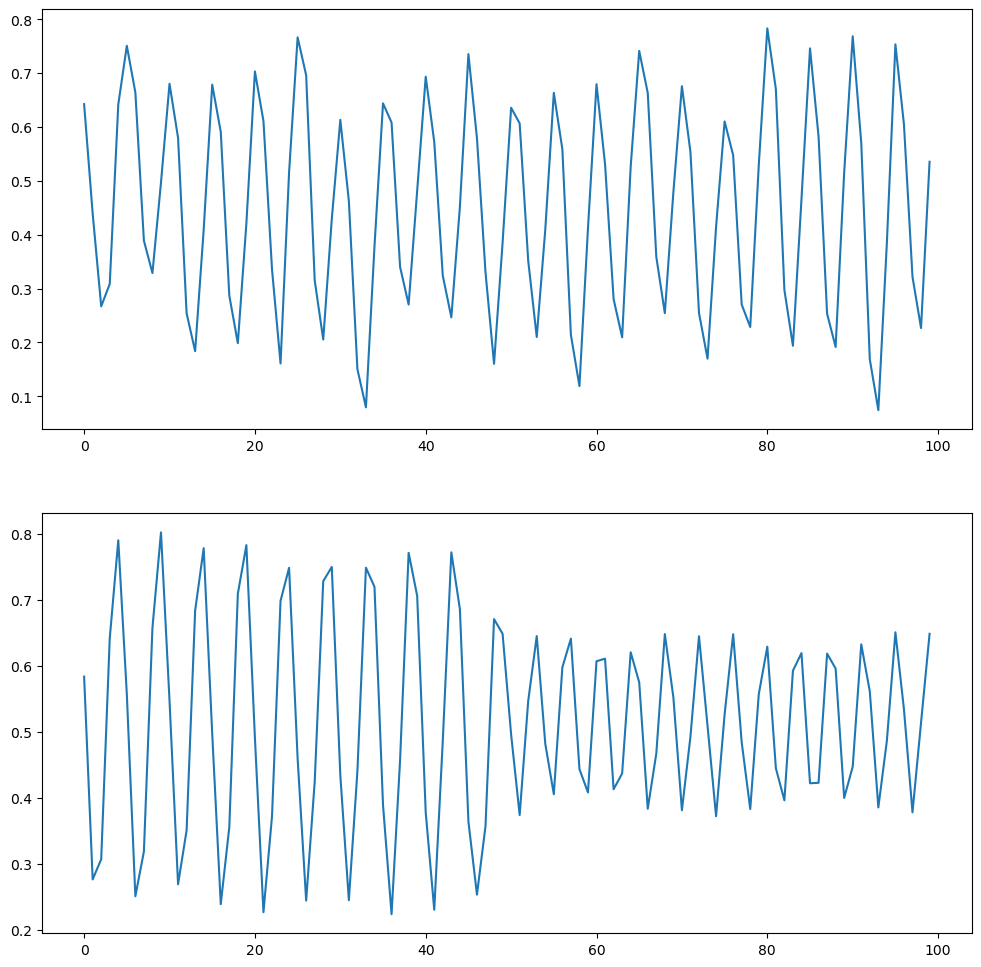

In [783]:
i = 100
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(trainX[i])
plt.subplot(212)
plt.plot(testX[i])
plt.show()

#### Prediction LSTM Autoencoder

In [652]:
model = keras.Sequential()
model.add(layers.LSTM(128, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(layers.RepeatVector(trainX.shape[1]))
model.add(layers.LSTM(128, activation='tanh'))
model.add(layers.Dense(trainX.shape[2]))

model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/50
7/7 [==============================] - 11s 1s/step - loss: 0.1069 - val_loss: 0.0891
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 0.0602 - val_loss: 0.0876
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.0579 - val_loss: 0.0855
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.0573 - val_loss: 0.0841
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.0555 - val_loss: 0.0834
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.0539 - val_loss: 0.0812
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.0529 - val_loss: 0.0798
Epoch 8/50
7/7 [==============================] - 7s 1s/step - loss: 0.0515 - val_loss: 0.0777
Epoch 9/50
7/7 [==============================] - 7s 1s/step - loss: 0.0508 - val_loss: 0.0761
Epoch 10/50
7/7 [==============================] - 8s 1s/step - loss: 0.0488 - val_loss: 0.0691
Epoch 11/50
7/7 [==============================]

#### Standard LSTM

In [765]:
model = keras.Sequential()
model.add(layers.LSTM(128, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(layers.LSTM(128, activation='tanh', return_sequences=False))
model.add(layers.Dense(trainX.shape[2]))

model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/50
7/7 [==============================] - 12s 1s/step - loss: 0.1424 - val_loss: 0.0906
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 0.0775 - val_loss: 0.1001
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.0663 - val_loss: 0.0999
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 0.0614 - val_loss: 0.0922
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.0613 - val_loss: 0.0904
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 0.0588 - val_loss: 0.0898
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.0588 - val_loss: 0.0886
Epoch 8/50
7/7 [==============================] - 8s 1s/step - loss: 0.0577 - val_loss: 0.0889
Epoch 9/50
7/7 [==============================] - 8s 1s/step - loss: 0.0576 - val_loss: 0.0869
Epoch 10/50
7/7 [==============================] - 8s 1s/step - loss: 0.0569 - val_loss: 0.0861
Epoch 11/50
7/7 [==============================]

In [784]:
test_mean_rec = model.predict(testX)

29/29 [==============================] - 3s 92ms/step


In [785]:
train_mean = train_mean[seq_size:]
train_mean = train_mean.reshape(train_mean.shape[0])

In [786]:
test_mean = test_mean[seq_size:]
test_mean = test_mean.reshape(test_mean.shape[0])

In [787]:
data.anomaly_timestamps = np.array(data.anomaly_timestamps)
data.anomaly_timestamps = data.anomaly_timestamps - seq_size

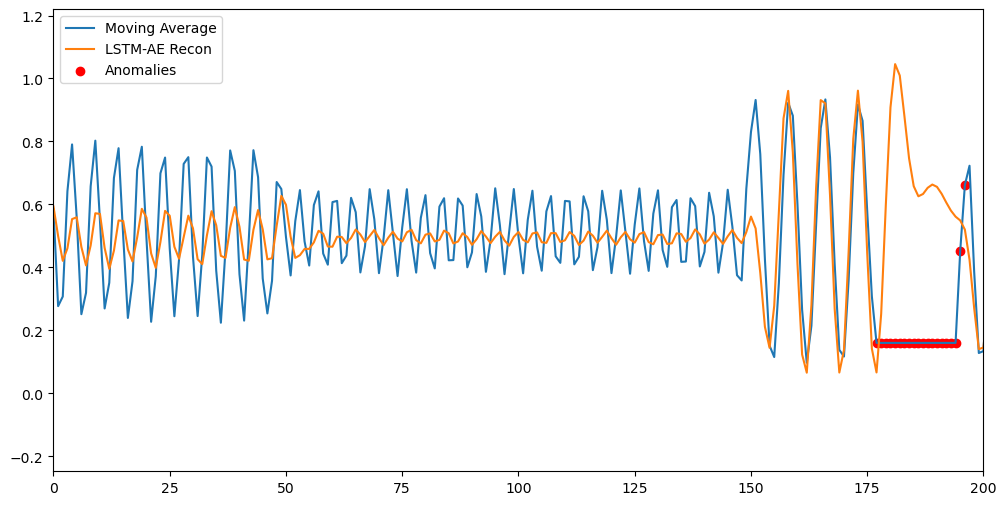

In [799]:
i = 0
plt.figure(figsize=(12, 6))
plt.plot(test_mean, label='Moving Average')
plt.plot(test_mean_rec, label="LSTM-AE Recon")
plt.scatter(data.anomaly_timestamps, test_mean[data.anomaly_timestamps], color='r', label='Anomalies')
plt.legend()
plt.xlim([i*100, i*100 + 200])
plt.show()

In [789]:
error = abs(test_mean - test_mean_rec.reshape(test_mean_rec.shape[0]))
error.shape

(901,)

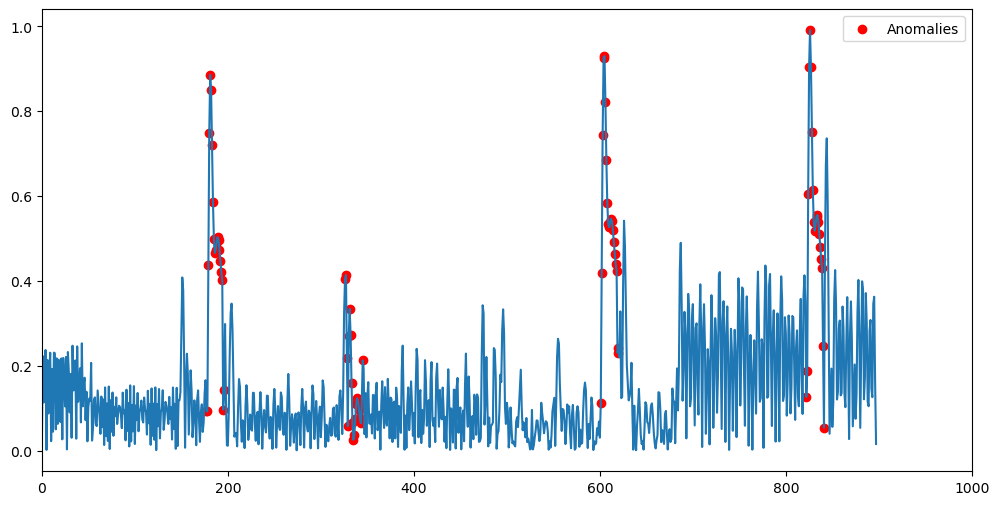

In [790]:
i = 0
plt.figure(figsize=(12, 6))
plt.plot(error[:-window_size])
plt.scatter(data.anomaly_timestamps, error[data.anomaly_timestamps], color='r', label='Anomalies')
plt.legend()
plt.xlim([i*1000, i*1000 + 1000])
plt.show()